In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
from matplotlib import pyplot as plt
from matplotlib import patches
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, f1_score
import pandas as pd
import xgboost as xgb
import pickle
import numpy as np
import seaborn as sns
import os

# README
Welcome stranger to converting an RandomSearchCV model to XGBoost classifier model, adding the nessecary CAPICE code and plotting the ROC_AUC curves (including some other fancy plots).

Steps:

1. Run "convert_randomsearchcv_to_XGBClassifier" with argument 1 being the location of the randomized search cv model (full path including the file itself) and argument 2, the location of where the model file should be including the file name.

1. Copy "capice_v1_0_0.py" in `src/main/python/resources/models` and paste it in the same folder naming it something else (note: do not start the name with double underscore or Template!)

1. Rename the class to something recognizeable and rename the "name" in the super() call of the init.

1. Copy the just renamed name of the super() variable to the config.cfg and paste it at [OVERWRITES]: modelfile = 

1. Run capice with the command `python3 capice.py -i /path/to/validation/dataset -o /path/to/recognizeable/output/folder

1. Run all above and including code cells where `plot_roc_curves` is defined.

1. Provide the full path to the datasets at each of the `pd.read_csv()` functions with their respective datasets. __Labels are hardcoded__.

1. Run the cell where datasets are loaded in.

1. Run All the cells at chapter [Plots](#Plots)


In [3]:
# Define your paths here!

old_model_output = '/home/rjsietsma/PycharmProjects/capice_updatr/datafiles/Compare_models/old/validate_vcf_vep_per_gene_capice.tsv.gz'
new_unbalanced_model_output = '/home/rjsietsma/PycharmProjects/capice_updatr/datafiles/Compare_models/mk1/unbalanced/validate_vcf_vep_per_gene_capice.tsv.gz'
new_balanced_model_output = '/home/rjsietsma/PycharmProjects/capice_updatr/datafiles/Compare_models/mk1/balanced/validate_vcf_vep_per_gene_capice.tsv.gz'

old_model_location = '/home/rjsietsma/PycharmProjects/capice/CAPICE_model/GRCh37/xgb_booster.pickle.dat'
new_unbalanced_model_location = '/home/rjsietsma/PycharmProjects/capice/CAPICE_model/GRCh37/POC/xgb_booster_mk1_unbalanced.pickle.dat'
new_balanced_model_location = '/home/rjsietsma/PycharmProjects/capice/CAPICE_model/GRCh37/POC/xgb_booster_mk1_balanced.pickle.dat'

In [4]:
def convert_randomsearchcv_to_XGBClassifier(randomsearchcv_loc, output_loc):
    if randomsearchcv_loc is not None and output_loc is not None:
        if os.path.isfile(randomsearchcv_loc):
            with open(randomsearchcv_loc, 'rb') as model_file:
                model = pickle.load(model_file)
            xgboost_model = model.best_estimator_
            if not os.path.exists(output_loc):
                os.makedirs(output_loc)
            with open(output_loc, 'wb') as new_model_file:
                pickle.dump(xgboost_model, new_model_file)
        else:
            print('Randomsearchcv is not a file!')

In [5]:
convert_randomsearchcv_to_XGBClassifier(None, None)

In [6]:
location_of_validate_csv = '/home/rjsietsma/PycharmProjects/capice_updatr/datafiles/Thresholds/validate.csv.gz'
validate = pd.read_csv(location_of_validate_csv, low_memory=False)
validate.drop_duplicates(inplace=True)
before_drop = validate.shape[0]
validate.drop(index=validate[(validate['ref'].str.len() > 50) | (validate['alt'].str.len() > 50)].index, inplace=True)
print(f'{before_drop - validate.shape[0]} CNVs dropped.')
merge_col = 'merge_col'
validate['b_label'] = 0
validate.loc[validate[validate['clinsig'] == 'LP'].index, 'b_label'] = 1
validate[merge_col] = validate[['chr', 'pos', 'ref', 'alt', 'gene']].astype(str).agg('_'.join, axis=1)
validate.drop(columns=['chr', 'pos', 'ref', 'alt', 'gene'], inplace=True)
clinvar_validate = validate[(validate['source'] == 'clinvar') & (validate['stars'] >= 2)]
vkgl_validate = validate[(validate['source'] == 'vkgl') & (validate['stars'] >= 1)]
validate = clinvar_validate.append(vkgl_validate)
validate.sort_index(inplace=True)
validate.reset_index(drop=True, inplace=True)
validate

388 CNVs dropped.


,clinsig,review,stars,source,merge_col,max_af,b_label
0,LB,"criteria_provided,_single_submitter",1,vkgl,1_898873_C_T_nan,NaN,0
1,LB,"criteria_provided,_single_submitter",1,vkgl,1_976110_G_A_nan,NaN,0
2,LB,"criteria_provided,_multiple_submitters,_no_con...",2,clinvar,1_977570_G_A_AGRN,0.97260,0
3,LB,"criteria_provided,_multiple_submitters,_no_con...",2,clinvar,1_979835_G_A_AGRN,0.08470,0
4,LB,"criteria_provided,_multiple_submitters,_no_con...",2,clinvar,1_980552_G_A_AGRN,0.00377,0
...,...,...,...,...,...,...,...
32976,LB,"criteria_provided,_multiple_submitters,_no_con...",2,clinvar,MT_4370_T_C_MT-TQ,0.00000,0
32977,LB,"criteria_provided,_multiple_submitters,_no_con...",2,clinvar,MT_7471_C_T_MT-TS1,0.00000,0
32978,LP,"criteria_provided,_multiple_submitters,_no_con...",2,clinvar,MT_8344_A_G_MT-TK,0.00000,1
32979,LB,"criteria_provided,_multiple_submitters,_no_con...",2,clinvar,MT_12346_C_T_MT-ND5,0.00000,0


In [7]:
def merge_capice_output(capice_output, validation_dataset):
    data_cols_merge = ['chr', 'pos', 'ref', 'alt', 'gene_name']
    drop_cols = ['review', 'source', merge_col]
    
    # Copying the dataset so changes will not be applied to the original dataset.
    output = capice_output.copy(deep=True)
    
    # Merging
    print('Merging')
    output[merge_col] = output[data_cols_merge].astype(str).agg('_'.join, axis=1)
    merged_output = output.merge(validation_dataset, on=[merge_col], how='left')
    merged_output.drop(columns=drop_cols, inplace=True)
    
    # Processing
    print('Processing')
    merged_output.drop_duplicates(inplace=True)
    merged_output.dropna(subset=['b_label'], inplace=True)
    merged_output['dif'] = abs(merged_output['score'] - merged_output['b_label'])
    merged_output.sort_values(by='dif', inplace=True)
    merged_output.drop_duplicates(subset=data_cols_merge, inplace=True)
    merged_output.sort_index(inplace=True)
    
    print('Done.')
    return merged_output

In [8]:
def plot_roc_curves(old_model, new_unbalanced_model, new_balanced_model):
    plt.rcParams['figure.figsize'] = (20,8)
    rounding = 4
    
    # Plotting
    fpr_old, tpr_old, _ = roc_curve(y_score = old_model['score'], y_true = old_model['b_label'])
    roc_auc_old = round(auc(fpr_old, tpr_old), rounding)
    plt.plot(fpr_old, tpr_old, color='black', label=f'Old (area={roc_auc_old})')
    
    # Plotting
    fpr_unbalanced, tpr_unbalanced, _ = roc_curve(y_score = np.array(new_unbalanced_model['score']), y_true = np.array(new_unbalanced_model['b_label']))
    roc_auc_unbalanced = round(auc(fpr_unbalanced, tpr_unbalanced), rounding)
    plt.plot(fpr_unbalanced, tpr_unbalanced, color='darkorange', label=f'Unbalanced (area={roc_auc_unbalanced})')
    
    # Plotting
    fpr_balanced, tpr_balanced, _ = roc_curve(y_score = np.array(new_balanced_model['score']), y_true = np.array(new_balanced_model['b_label']))
    roc_auc_balanced = round(auc(fpr_balanced, tpr_balanced), rounding)
    plt.plot(fpr_balanced, tpr_balanced, color='blue', label=f'Balanced (area={roc_auc_balanced})')
    
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('CAPICE Receiver operating characteristics')
    plt.legend()
    plt.show()

In [9]:
x = np.ones(3)
isinstance(x, np.ndarray)

True

In [10]:
def plot_violin(old_model, new_unbalanced_model, new_balanced_model):
    fig, axes = plt.subplots(1, 3, figsize=(20,8), sharey=True)
    sns.violinplot(ax=axes[0], x='clinsig', y='score', data=old_model)
    axes[0].set_title('Old')
    axes[0].legend(handles=[
        patches.Patch(color='white', label=f'LB: {old_model[old_model["clinsig"] == "LB"].shape[0]}', alpha=0.0),
        patches.Patch(color='white', label=f'LP: {old_model[old_model["clinsig"] == "LP"].shape[0]}', alpha=0.0)
    ])
    sns.violinplot(ax=axes[1], x='clinsig', y='score', data=new_unbalanced_model)
    axes[1].set_title('Unbalanced')
    axes[1].legend(handles=[
        patches.Patch(color='white', label=f'LB: {new_unbalanced_model[new_unbalanced_model["clinsig"] == "LB"].shape[0]}', alpha=0.0),
        patches.Patch(color='white', label=f'LP: {new_unbalanced_model[new_unbalanced_model["clinsig"] == "LP"].shape[0]}', alpha=0.0)
    ])
    sns.violinplot(ax=axes[2], x='clinsig', y='score', data=new_balanced_model)
    axes[2].set_title('Balanced')
    axes[2].legend(handles=[
        patches.Patch(color='white', label=f'LB: {new_balanced_model[new_balanced_model["clinsig"] == "LB"].shape[0]}', alpha=0.0),
        patches.Patch(color='white', label=f'LP: {new_balanced_model[new_balanced_model["clinsig"] == "LP"].shape[0]}', alpha=0.0)
    ])
    plt.show()

In [11]:
def plot_allele_frequencies(old_model, new_unbalanced_model, new_balanced_model):
    fig, axes = plt.subplots(1, 3, figsize=(20,8), sharey=True)
    for ax in axes:
        ax.axes.xaxis.set_visible(False)
    bins = [[0,0.0001], [0.0001, 0.001], [0.001, 0.01], [0.01, 0.1], [0.1, 1]]
    cols = {
        0: 'black',
        1: 'purple',
        2: 'grey',
        3: 'lightgreen',
        4: 'blue'
    }
    n_in_bins = {
        0: 0,
        1: 0,
        2: 0,
        3: 0,
        4: 0
    }
    for current_bin, b in enumerate(bins):
        subset = old_model[(old_model['max_af'] > min(b)) & (old_model['max_af'] <= max(b))]
        n_in_bins[current_bin] = subset.shape[0]
    
    for current_bin, b in enumerate(bins):
        subset_old = old_model[(old_model['max_af'] > min(b)) & (old_model['max_af'] <= max(b))]
        fpr_old, tpr_old, _ = roc_curve(y_score = np.array(subset_old['score']), y_true=np.array(subset_old['b_label']))
        auc_old = auc(fpr_old, tpr_old)
        stdev_old = np.std(auc_old)
        axes[0].errorbar(current_bin, auc_old, yerr=stdev_old, fmt='o', color=cols[current_bin])
        axes[0].set_title('Old')
        axes[0].set_ylabel('AUC')
        
        subset_un = new_unbalanced_model[(new_unbalanced_model['max_af'] > min(b)) & (new_unbalanced_model['max_af'] <= max(b))]
        fpr_un, tpr_un, _ = roc_curve(y_score = np.array(subset_un['score']), y_true=np.array(subset_un['b_label']))
        auc_un = auc(fpr_un, tpr_un)
        stdev_un = np.std(auc_un)
        axes[1].errorbar(current_bin, auc_un, yerr=stdev_un, fmt='o', color=cols[current_bin])
        axes[1].set_title('Unbalanced')
        
        subset_b = new_balanced_model[(new_balanced_model['max_af'] > min(b)) & (new_balanced_model['max_af'] <= max(b))]
        fpr_b, tpr_b, _ = roc_curve(y_score = np.array(subset_b['score']), y_true=np.array(subset_b['b_label']))
        auc_b = auc(fpr_b, tpr_b)
        stdev_b = np.std(auc_b)
        axes[2].errorbar(current_bin, auc_b, yerr=stdev_b, fmt='o', color=cols[current_bin])
        axes[2].set_title('Balanced')
    handles = []
    for index, color in cols.items():
        handles.append(patches.Patch(color=color, label=f'{min(bins[index])}%~{max(bins[index])}%\n(n={n_in_bins[index]})'))
    fig.legend(handles=handles, loc='upper left')
    fig.suptitle('AUC distribution over different allele frequencies')
    plt.subplots_adjust(wspace=0.01)
    plt.show()

In [12]:
def plot_feature_importances(old_model, new_unbalanced_model, new_balanced_model):
    fig, axes = plt.subplots(13, 10, figsize=(30, 40), sharex=True)
    old_model_importances = pd.DataFrame.from_dict(old_model.get_score(importance_type='gain'), orient='index')
    old_model_importances['feature'] = old_model_importances.index
    old_model_importances.columns = ['value', 'feature']
    old_model_importances.reset_index(drop=True, inplace=True)
    
    new_unbalanced_model_importances = pd.DataFrame.from_dict(new_unbalanced_model._Booster.get_score(importance_type='gain'), orient='index')
    new_unbalanced_model_importances['feature'] = new_unbalanced_model_importances.index
    new_unbalanced_model_importances.columns = ['value_unbalanced', 'feature']
    new_unbalanced_model_importances.reset_index(drop=True, inplace=True)
    
    new_balanced_model_importances = pd.DataFrame.from_dict(new_balanced_model._Booster.get_score(importance_type='gain'), orient='index')
    new_balanced_model_importances['feature'] = new_balanced_model_importances.index
    new_balanced_model_importances.columns = ['value_balanced', 'feature']
    new_balanced_model_importances.reset_index(drop=True, inplace=True)
    
    old_model_importances = old_model_importances.merge(new_unbalanced_model_importances, on=['feature'], how='left')
    old_model_importances = old_model_importances.merge(new_balanced_model_importances, on=['feature'], how='left')
    col_num = 0
    row_num = 0
    n_tot = 0
    
    n_top = 5
    print(f'Top {n_top} most important features in the old model:')
    print(old_model_importances[['feature', 'value']].sort_values(by='value', ascending=False).reset_index(drop=True)[:n_top])
    print('\n')
    
    print(f'Top {n_top} most important features in the new unbalanced model:')
    print(old_model_importances[['feature', 'value_unbalanced']].sort_values(by='value_unbalanced', ascending=False).reset_index(drop=True)[:n_top])
    print('\n')
    
    print(f'Top {n_top} most important features in the new balanced model:')
    print(old_model_importances[['feature', 'value_balanced']].sort_values(by='value_balanced', ascending=False).reset_index(drop=True)[:n_top])
    print('\n')
    
    for feature in np.sort(old_model_importances['feature'].unique()):
        subset = old_model_importances[old_model_importances['feature'] == feature]
        axes[row_num, col_num].bar(0, subset['value'], width=1.0, color='black', align='center')
        axes[row_num, col_num].bar(1, subset['value_unbalanced'], width=1.0, color='orange', align='center')
        axes[row_num, col_num].bar(2, subset['value_balanced'], width=1.0, color='blue', align='center')
        axes[row_num, col_num].set_title(feature)
        col_num += 1
        n_tot += 1
        if n_tot == old_model_importances.shape[0]:
            fig.delaxes(axes[row_num, col_num])
        if col_num > 9:
            col_num = 0
            row_num += 1
        
    fig.suptitle('Feature Importances Comparison between models')
    
    n_feats_old = old_model_importances[old_model_importances['value'].notnull()].shape[0]
    n_feats_unbalanced = old_model_importances[old_model_importances['value_unbalanced'].notnull()].shape[0]
    n_feats_balanced = old_model_importances[old_model_importances['value_balanced'].notnull()].shape[0]
    
    handles = [
        patches.Patch(color='black', label=f'Old (n={n_feats_old})'),
        patches.Patch(color='orange', label=f'Unbalanced (n={n_feats_unbalanced})'),
        patches.Patch(color='blue', label=f'Balanced (n={n_feats_balanced})')
    ]
    fig.legend(handles=handles)
    
    plt.show()

# Data Loading

In [13]:
old_model = pd.read_csv(old_model_output, sep='\t', low_memory=False)
old_model.drop(index=old_model[old_model['id_source'] != 'HGNC'].index, inplace=True)
merged_old_model = merge_capice_output(old_model, validate)

new_unbalanced_model = pd.read_csv(new_unbalanced_model_output, sep='\t', low_memory=False)
new_unbalanced_model.drop(index=new_unbalanced_model[new_unbalanced_model['id_source'] != 'HGNC'].index, inplace=True)
merged_unbalanced_model = merge_capice_output(new_unbalanced_model, validate)

new_balanced_model = pd.read_csv(new_balanced_model_output, sep='\t', low_memory=False)
new_balanced_model.drop(index=new_balanced_model[new_balanced_model['id_source'] != 'HGNC'].index, inplace=True)
merged_balanced_model = merge_capice_output(new_balanced_model, validate)

Merging
Processing
Done.
Merging
Processing
Done.
Merging
Processing
Done.


In [14]:
with open(old_model_location, 'rb') as old_model_file:
    old_model = pickle.load(old_model_file)
    
with open(new_unbalanced_model_location, 'rb') as new_unbalanced_model_file:
    new_unbalanced_model = pickle.load(new_unbalanced_model_file)
    
with open(new_balanced_model_location, 'rb') as new_balanced_model_file:
    new_balanced_model = pickle.load(new_balanced_model_file)

# Plots

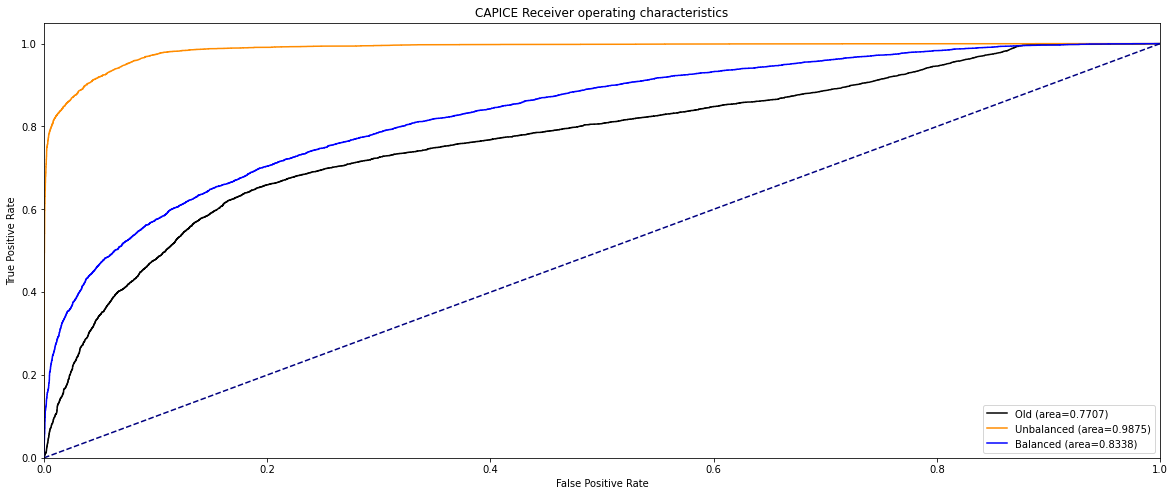

In [15]:
plot_roc_curves(merged_old_model, merged_unbalanced_model, merged_balanced_model)

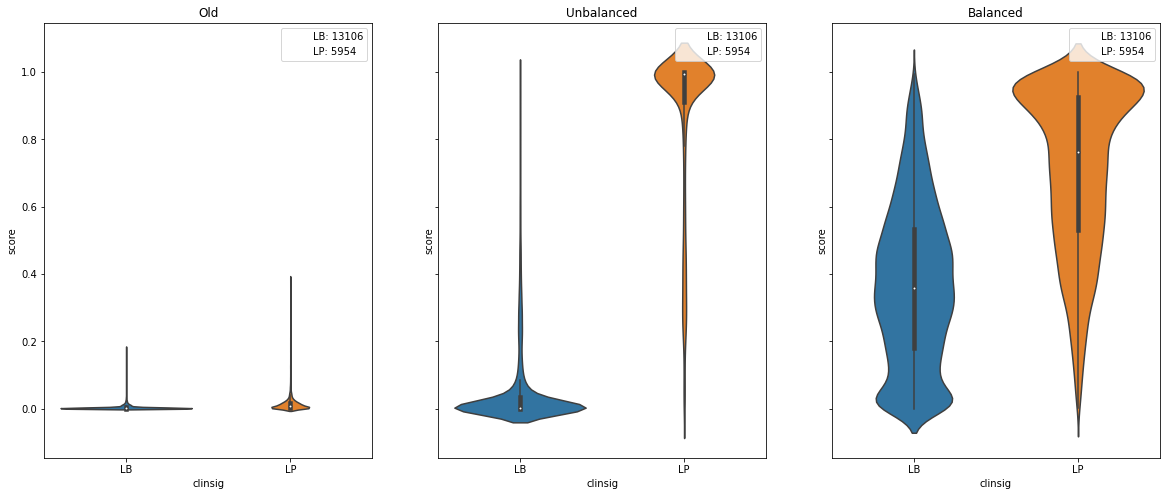

In [16]:
plot_violin(merged_old_model, merged_unbalanced_model, merged_balanced_model)

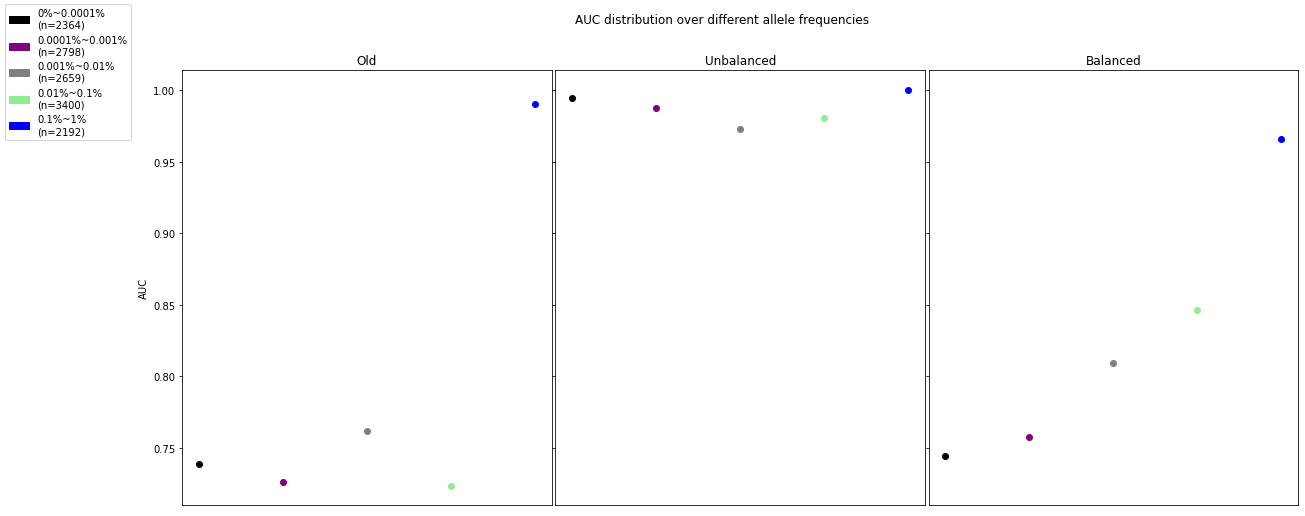

In [17]:
plot_allele_frequencies(merged_old_model, merged_unbalanced_model, merged_balanced_model)

Top 5 most important features in the old model:
              feature      value
0           nAA_other  94.432263
1            Type_DEL  88.065660
2  PolyPhenCat_benign  48.160691
3            Type_SNV  18.284462
4             SIFTval  18.132311


Top 5 most important features in the new unbalanced model:
       feature  value_unbalanced
0        nAA_L         32.268560
1    nAA_other         30.361167
2     Type_SNV         29.241931
3  PolyPhenVal         28.113486
4      SIFTval         20.162205


Top 5 most important features in the new balanced model:
               feature  value_balanced
0   PolyPhenCat_benign      286.290110
1             Type_SNV      201.542928
2  SIFTcat_deleterious       64.285010
3               Length       11.403525
4              SIFTval        7.002389




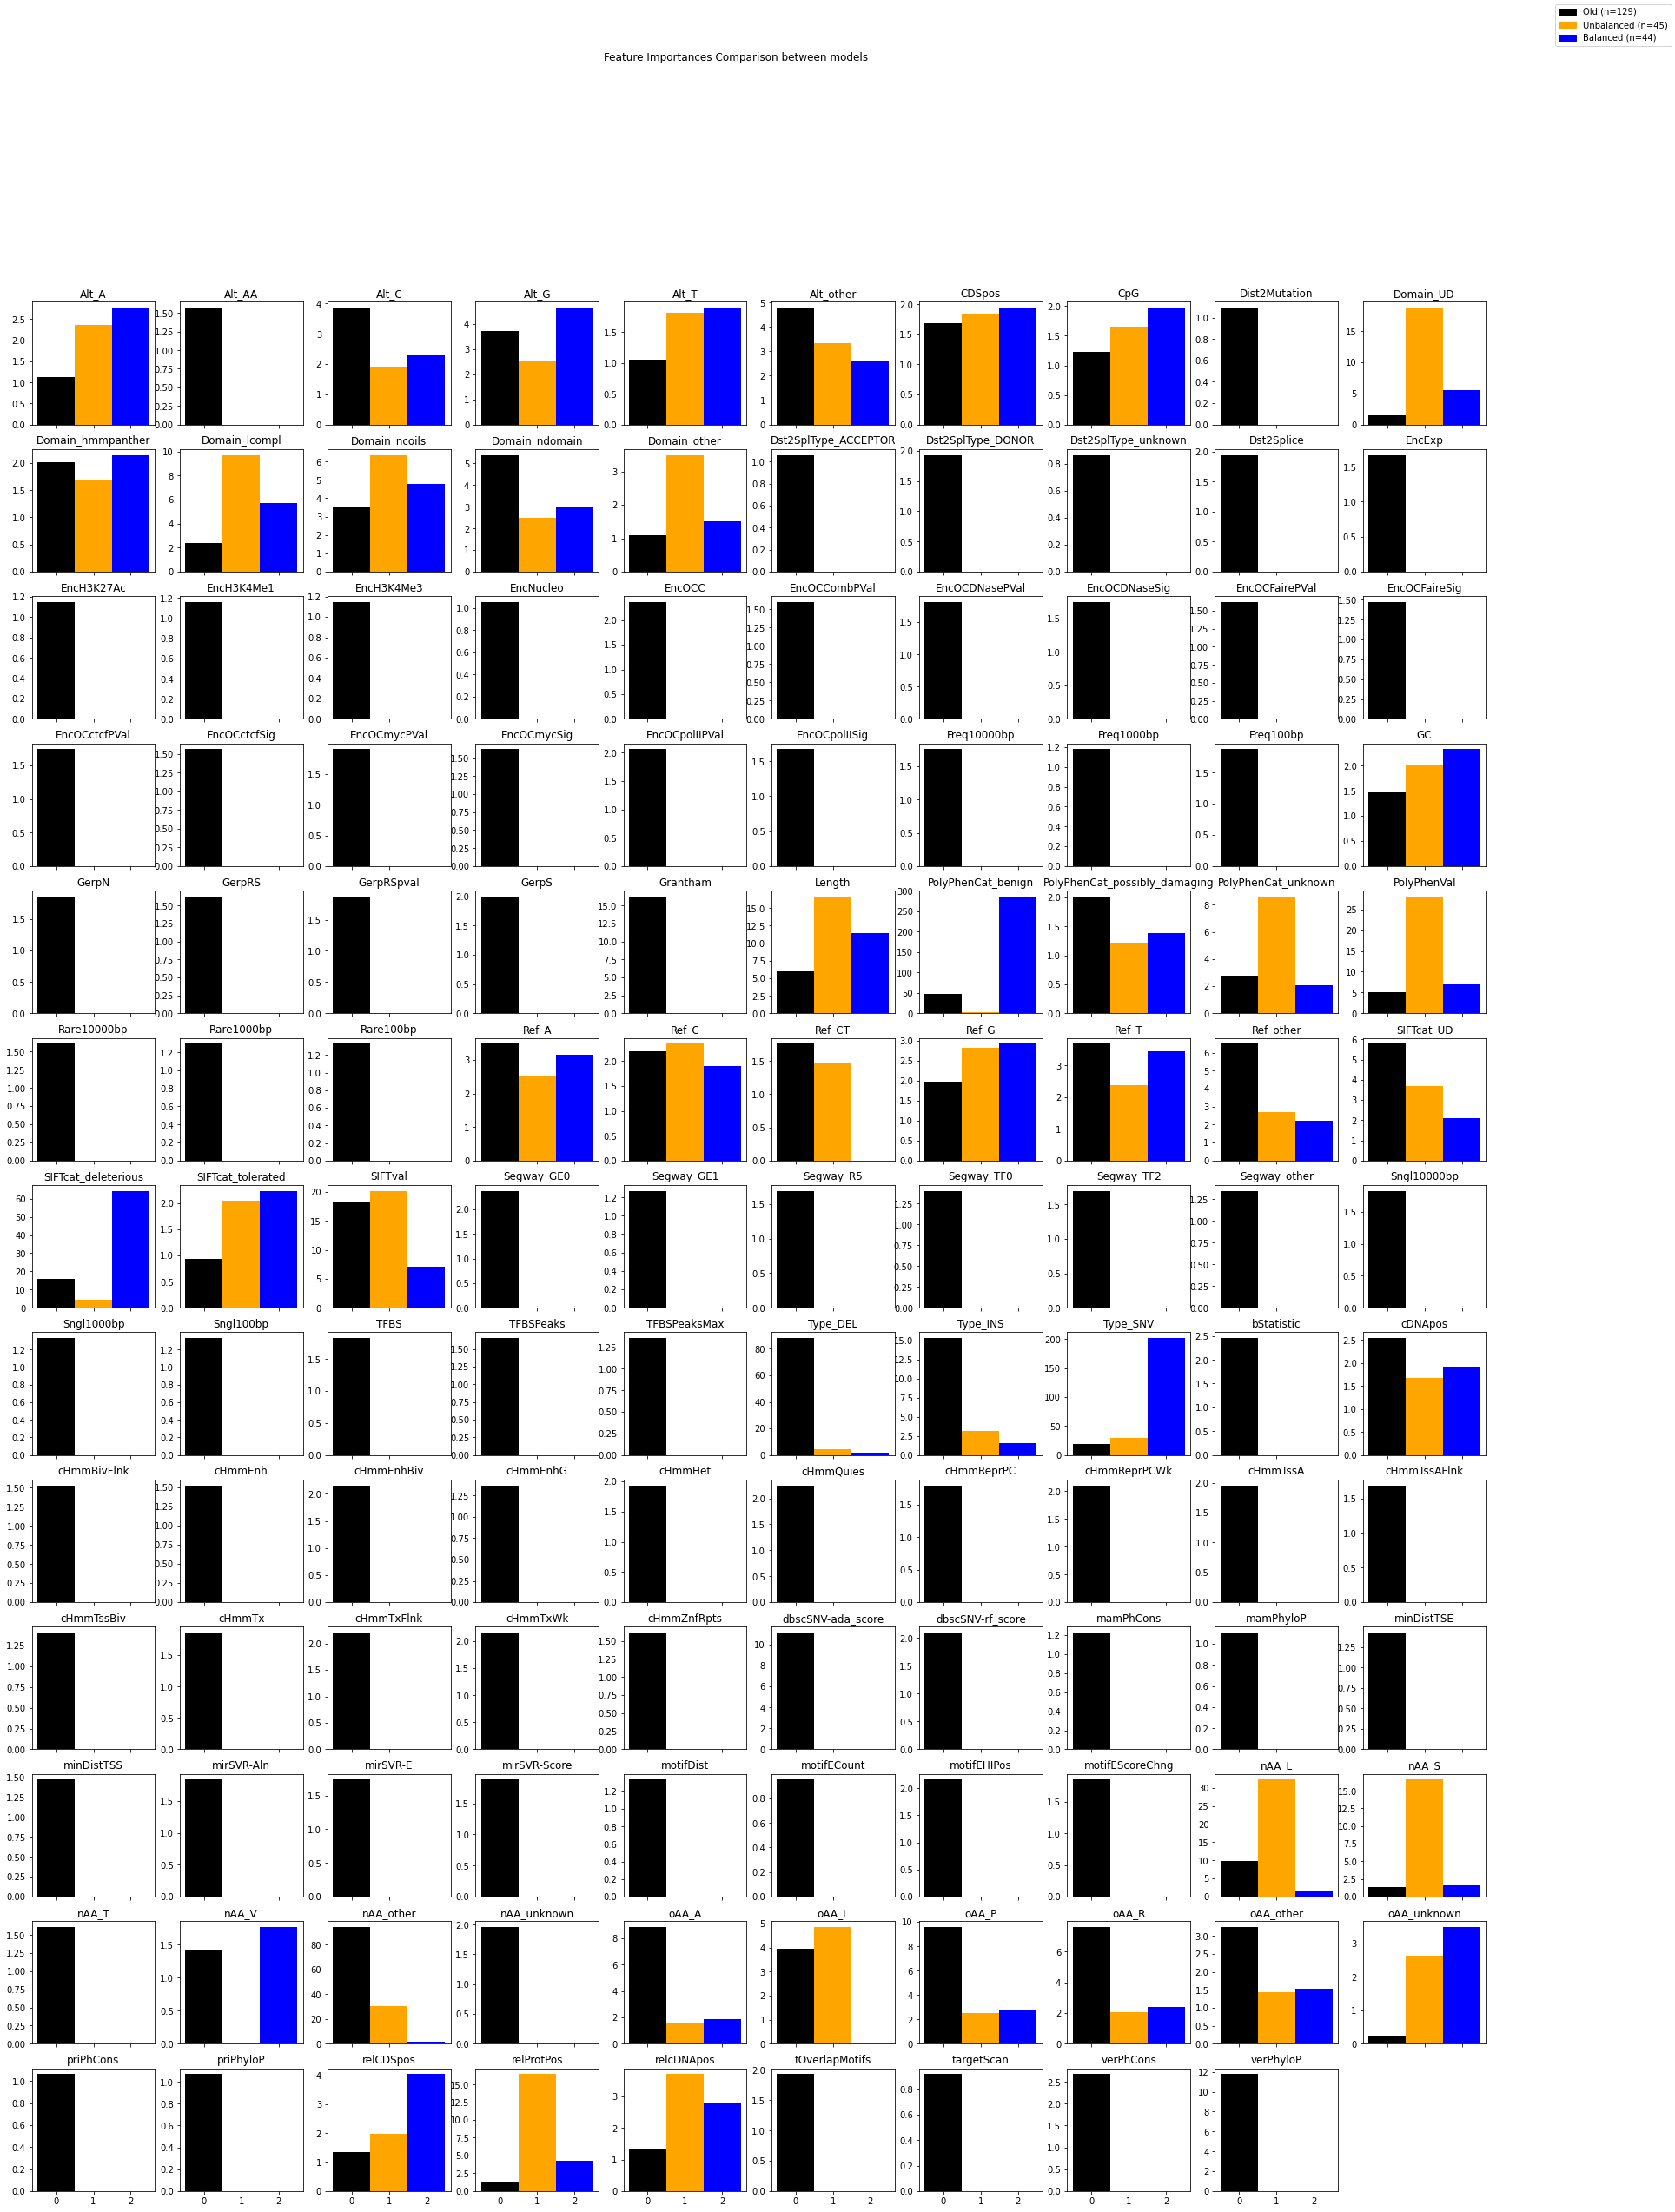

In [18]:
plot_feature_importances(old_model, new_unbalanced_model, new_balanced_model)

# Validate with Li et al. validation dataset

In [19]:
old_validation_dataset = pd.read_csv('/home/rjsietsma/PycharmProjects/capice_updatr/datafiles/Compare_models/test.txt.gz', sep='\t')
old_validation_dataset = old_validation_dataset[['CHROM', 'Pos', 'Ref', 'Alt', 'SYMBOL', 'binarized_label', 'max_AF']]
old_validation_dataset['merge_col'] = old_validation_dataset[['CHROM', 'Pos', 'Ref', 'Alt', 'SYMBOL']].astype(str).agg('_'.join, axis=1)
old_validation_dataset = old_validation_dataset[['merge_col', 'binarized_label', 'max_AF']]
old_validation_dataset.rename(columns={'binarized_label': 'b_label', 'max_AF': 'max_af'}, inplace=True)

old_old_dataset = pd.read_csv('/home/rjsietsma/PycharmProjects/capice_updatr/datafiles/Compare_models/old/test_capice.txt.gz', sep='\t')
old_old_dataset = old_old_dataset[['chr', 'pos', 'ref', 'alt', 'gene_name', 'score']]
old_old_dataset['merge_col'] = old_old_dataset[['chr', 'pos', 'ref', 'alt', 'gene_name']].astype(str).agg('_'.join, axis=1)
old_old_dataset = old_old_dataset[['merge_col', 'score']]

old_balanced_dataset = pd.read_csv('/home/rjsietsma/PycharmProjects/capice_updatr/datafiles/Compare_models/mk1/balanced/test_capice.txt.gz', sep='\t')
old_balanced_dataset = old_balanced_dataset[['chr', 'pos', 'ref', 'alt', 'gene_name', 'score']]
old_balanced_dataset['merge_col'] = old_balanced_dataset[['chr', 'pos', 'ref', 'alt', 'gene_name']].astype(str).agg('_'.join, axis=1)
old_balanced_dataset = old_balanced_dataset[['merge_col', 'score']]

old_unbalanced_dataset = pd.read_csv('/home/rjsietsma/PycharmProjects/capice_updatr/datafiles/Compare_models/mk1/unbalanced/test_capice.txt.gz', sep='\t')
old_unbalanced_dataset = old_unbalanced_dataset[['chr', 'pos', 'ref', 'alt', 'gene_name', 'score']]
old_unbalanced_dataset['merge_col'] = old_unbalanced_dataset[['chr', 'pos', 'ref', 'alt', 'gene_name']].astype(str).agg('_'.join, axis=1)
old_unbalanced_dataset = old_unbalanced_dataset[['merge_col', 'score']]


/home/rjsietsma/PycharmProjects/capice_updatr/venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (55,63,73,112) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


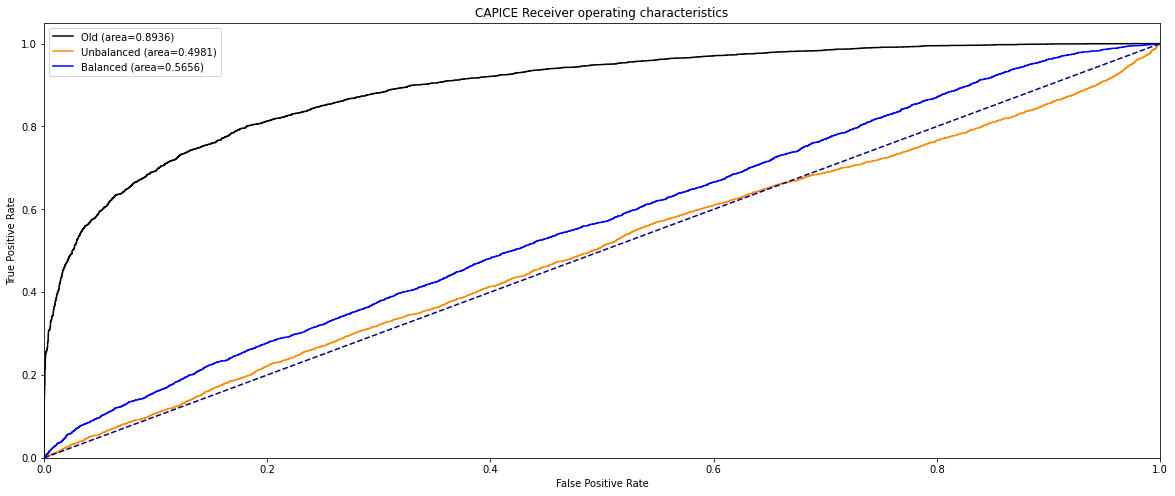

In [21]:
old_merge = old_old_dataset.merge(old_validation_dataset, on=['merge_col'], how='left')
old_merge['clinsig'] = 'LB'
old_merge.loc[old_merge[old_merge['b_label'] == 1].index, 'clinsig'] = 'LP'

balanced_merge = old_balanced_dataset.merge(old_validation_dataset, on=['merge_col'], how='left')
balanced_merge['clinsig'] = 'LB'
balanced_merge.loc[balanced_merge[balanced_merge['b_label'] == 1].index, 'clinsig'] = 'LP'

unbalanced_merge = old_unbalanced_dataset.merge(old_validation_dataset, on=['merge_col'], how='left')
unbalanced_merge['clinsig'] = 'LB'
unbalanced_merge.loc[unbalanced_merge[unbalanced_merge['b_label'] == 1].index, 'clinsig'] = 'LP'

plot_roc_curves(old_model=old_merge, new_unbalanced_model=unbalanced_merge, new_balanced_model=balanced_merge)

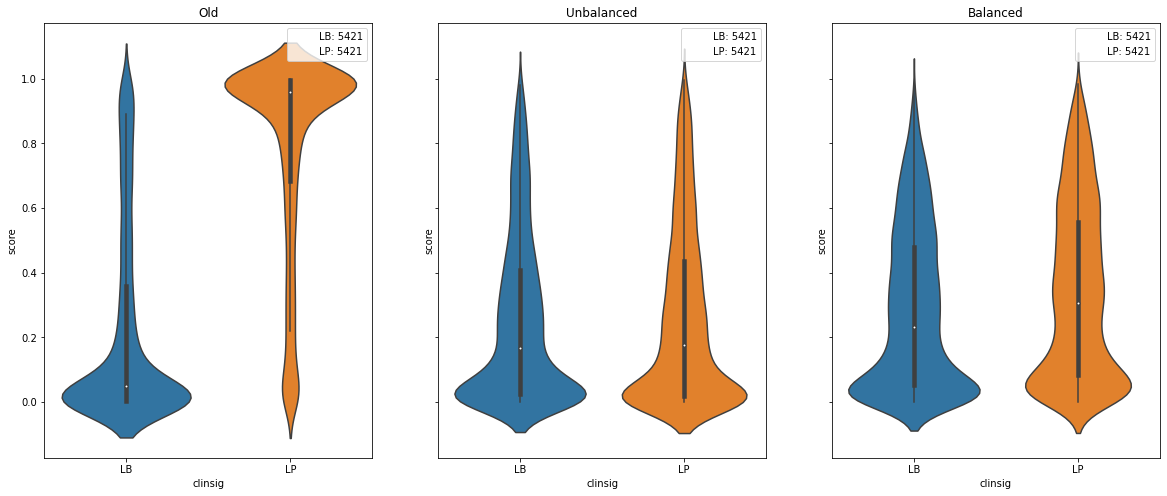

In [22]:
plot_violin(old_model=old_merge, new_balanced_model=balanced_merge, new_unbalanced_model=unbalanced_merge)

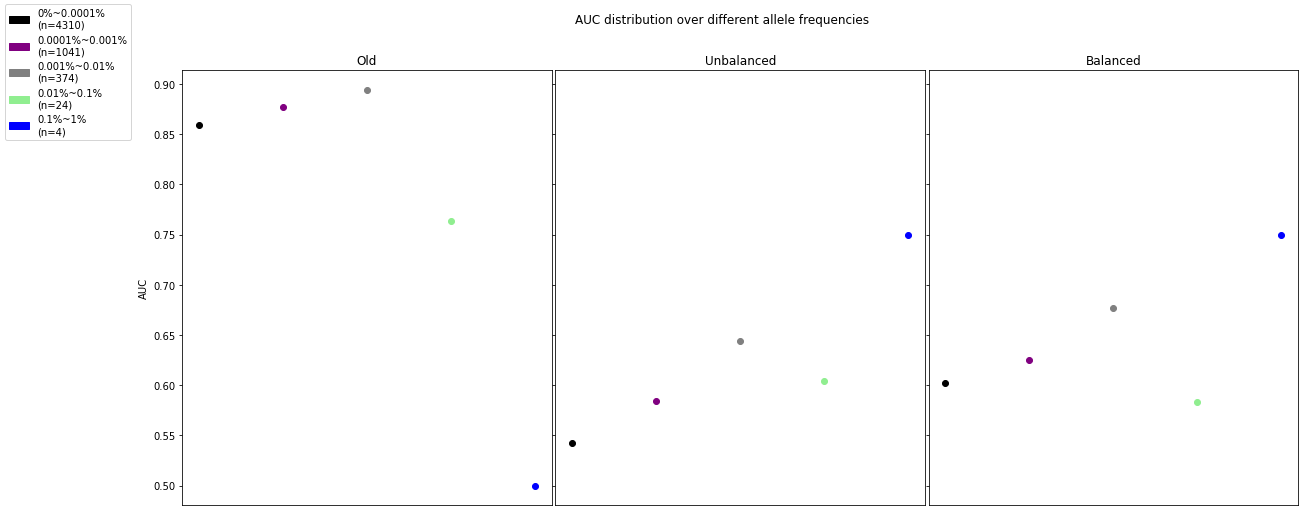

In [24]:
plot_allele_frequencies(old_model=old_merge, new_unbalanced_model=unbalanced_merge, new_balanced_model=balanced_merge)

# Notes
- New balanced model seems to outperform massively
- Most features in the new balanced model resolved around proteins are found to be important (nAA / oAA)
- Testing with the validation dataset used by Li et al. shows the exact opposite of what I found with my validation dataset. Is there something wrong with my validation dataset? Investigate. -> Possible: bad quality validation samples (0 stars for example) are still in the validation dataset, could be of influence.

In [25]:
validate

,clinsig,review,stars,source,merge_col,max_af,b_label
0,LB,"criteria_provided,_single_submitter",1,vkgl,1_898873_C_T_nan,NaN,0
1,LB,"criteria_provided,_single_submitter",1,vkgl,1_976110_G_A_nan,NaN,0
2,LB,"criteria_provided,_multiple_submitters,_no_con...",2,clinvar,1_977570_G_A_AGRN,0.97260,0
3,LB,"criteria_provided,_multiple_submitters,_no_con...",2,clinvar,1_979835_G_A_AGRN,0.08470,0
4,LB,"criteria_provided,_multiple_submitters,_no_con...",2,clinvar,1_980552_G_A_AGRN,0.00377,0
...,...,...,...,...,...,...,...
32976,LB,"criteria_provided,_multiple_submitters,_no_con...",2,clinvar,MT_4370_T_C_MT-TQ,0.00000,0
32977,LB,"criteria_provided,_multiple_submitters,_no_con...",2,clinvar,MT_7471_C_T_MT-TS1,0.00000,0
32978,LP,"criteria_provided,_multiple_submitters,_no_con...",2,clinvar,MT_8344_A_G_MT-TK,0.00000,1
32979,LB,"criteria_provided,_multiple_submitters,_no_con...",2,clinvar,MT_12346_C_T_MT-ND5,0.00000,0


In [26]:
validate['clinsig'].value_counts()

LB    24629
LP     8352
Name: clinsig, dtype: int64

In [27]:
train_dataset = pd.read_csv('/home/rjsietsma/PycharmProjects/capice_updatr/datafiles/Compare_models/train_vcf_vep_per_gene.tsv.gz', sep='\t', skiprows=2, na_values='.', low_memory=False)
train_dataset

,%CHROM,%POS,%REF,%ALT,%Consequence,%SYMBOL,%SYMBOL_SOURCE,%HGNC_ID,%Feature,%cDNA_position,...,%PolyPhen,%DOMAINS,%MOTIF_NAME,%HIGH_INF_POS,%MOTIF_SCORE_CHANGE,%EXON,%INTRON,%MAX_AF,binarized_label,sample_weight
0,1,69334,C,T,missense_variant,OR4F5,HGNC,14825,ENST00000335137,244/918,...,benign(0),PANTHER:PTHR26451&PANTHER:PTHR26451:SF72&Gene3...,NaN,NaN,NaN,1/1,NaN,0.000101,0,0.7
1,1,865519,C,T,intron_variant,SAMD11,HGNC,28706,ENST00000342066,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2/13,0.000253,0,0.7
2,1,865545,G,A,missense_variant,SAMD11,HGNC,28706,ENST00000342066,166/2551,...,possibly_damaging(0.778),PANTHER:PTHR12247&PANTHER:PTHR12247:SF67,NaN,NaN,NaN,3/14,NaN,0.012900,0,0.7
3,1,865567,C,T,synonymous_variant,SAMD11,HGNC,28706,ENST00000342066,188/2551,...,NaN,PANTHER:PTHR12247&PANTHER:PTHR12247:SF67,NaN,NaN,NaN,3/14,NaN,0.000232,0,0.7
4,1,865579,C,T,synonymous_variant,SAMD11,HGNC,28706,ENST00000342066,200/2551,...,NaN,PANTHER:PTHR12247&PANTHER:PTHR12247:SF67,NaN,NaN,NaN,3/14,NaN,0.000210,0,0.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
604473,MT,16017,T,C,downstream_gene_variant,MT-TL2,HGNC,7491,ENST00000387456,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0,0.7
604474,MT,16017,T,C,upstream_gene_variant,MT-ND6,HGNC,7462,ENST00000361681,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0,0.7
604475,MT,16017,T,C,non_coding_transcript_exon_variant,MT-TP,HGNC,7494,ENST00000387461,7/68,...,NaN,NaN,NaN,NaN,NaN,1/1,NaN,0.000000,0,0.7
604476,MT,16017,T,C,upstream_gene_variant,MT-TE,HGNC,7479,ENST00000387459,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0,0.7


In [28]:
new_cols = []
for col in train_dataset.columns:
    if col.startswith('%'):
        new_cols.append(col.split('%')[1])
    else:
        new_cols.append(col)
train_dataset.columns = new_cols
train_dataset.rename(columns={'CHROM': 'chr', 'POS': 'pos', 'REF': 'ref', 'ALT': 'alt', 'SYMBOL': 'gene_name'}, inplace=True)
train_dataset

,chr,pos,ref,alt,Consequence,gene_name,SYMBOL_SOURCE,HGNC_ID,Feature,cDNA_position,...,PolyPhen,DOMAINS,MOTIF_NAME,HIGH_INF_POS,MOTIF_SCORE_CHANGE,EXON,INTRON,MAX_AF,binarized_label,sample_weight
0,1,69334,C,T,missense_variant,OR4F5,HGNC,14825,ENST00000335137,244/918,...,benign(0),PANTHER:PTHR26451&PANTHER:PTHR26451:SF72&Gene3...,NaN,NaN,NaN,1/1,NaN,0.000101,0,0.7
1,1,865519,C,T,intron_variant,SAMD11,HGNC,28706,ENST00000342066,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2/13,0.000253,0,0.7
2,1,865545,G,A,missense_variant,SAMD11,HGNC,28706,ENST00000342066,166/2551,...,possibly_damaging(0.778),PANTHER:PTHR12247&PANTHER:PTHR12247:SF67,NaN,NaN,NaN,3/14,NaN,0.012900,0,0.7
3,1,865567,C,T,synonymous_variant,SAMD11,HGNC,28706,ENST00000342066,188/2551,...,NaN,PANTHER:PTHR12247&PANTHER:PTHR12247:SF67,NaN,NaN,NaN,3/14,NaN,0.000232,0,0.7
4,1,865579,C,T,synonymous_variant,SAMD11,HGNC,28706,ENST00000342066,200/2551,...,NaN,PANTHER:PTHR12247&PANTHER:PTHR12247:SF67,NaN,NaN,NaN,3/14,NaN,0.000210,0,0.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
604473,MT,16017,T,C,downstream_gene_variant,MT-TL2,HGNC,7491,ENST00000387456,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0,0.7
604474,MT,16017,T,C,upstream_gene_variant,MT-ND6,HGNC,7462,ENST00000361681,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0,0.7
604475,MT,16017,T,C,non_coding_transcript_exon_variant,MT-TP,HGNC,7494,ENST00000387461,7/68,...,NaN,NaN,NaN,NaN,NaN,1/1,NaN,0.000000,0,0.7
604476,MT,16017,T,C,upstream_gene_variant,MT-TE,HGNC,7479,ENST00000387459,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0,0.7


In [29]:
validate

,clinsig,review,stars,source,merge_col,max_af,b_label
0,LB,"criteria_provided,_single_submitter",1,vkgl,1_898873_C_T_nan,NaN,0
1,LB,"criteria_provided,_single_submitter",1,vkgl,1_976110_G_A_nan,NaN,0
2,LB,"criteria_provided,_multiple_submitters,_no_con...",2,clinvar,1_977570_G_A_AGRN,0.97260,0
3,LB,"criteria_provided,_multiple_submitters,_no_con...",2,clinvar,1_979835_G_A_AGRN,0.08470,0
4,LB,"criteria_provided,_multiple_submitters,_no_con...",2,clinvar,1_980552_G_A_AGRN,0.00377,0
...,...,...,...,...,...,...,...
32976,LB,"criteria_provided,_multiple_submitters,_no_con...",2,clinvar,MT_4370_T_C_MT-TQ,0.00000,0
32977,LB,"criteria_provided,_multiple_submitters,_no_con...",2,clinvar,MT_7471_C_T_MT-TS1,0.00000,0
32978,LP,"criteria_provided,_multiple_submitters,_no_con...",2,clinvar,MT_8344_A_G_MT-TK,0.00000,1
32979,LB,"criteria_provided,_multiple_submitters,_no_con...",2,clinvar,MT_12346_C_T_MT-ND5,0.00000,0


In [30]:
validate[['chr', 'pos', 'ref', 'alt', 'gene_name']] = validate['merge_col'].str.split('_', expand=True)
validate.loc[validate[validate['gene_name'] == 'nan'].index, 'gene_name'] = np.nan
validate

,clinsig,review,stars,source,merge_col,max_af,b_label,chr,pos,ref,alt,gene_name
0,LB,"criteria_provided,_single_submitter",1,vkgl,1_898873_C_T_nan,NaN,0,1,898873,C,T,NaN
1,LB,"criteria_provided,_single_submitter",1,vkgl,1_976110_G_A_nan,NaN,0,1,976110,G,A,NaN
2,LB,"criteria_provided,_multiple_submitters,_no_con...",2,clinvar,1_977570_G_A_AGRN,0.97260,0,1,977570,G,A,AGRN
3,LB,"criteria_provided,_multiple_submitters,_no_con...",2,clinvar,1_979835_G_A_AGRN,0.08470,0,1,979835,G,A,AGRN
4,LB,"criteria_provided,_multiple_submitters,_no_con...",2,clinvar,1_980552_G_A_AGRN,0.00377,0,1,980552,G,A,AGRN
...,...,...,...,...,...,...,...,...,...,...,...,...
32976,LB,"criteria_provided,_multiple_submitters,_no_con...",2,clinvar,MT_4370_T_C_MT-TQ,0.00000,0,MT,4370,T,C,MT-TQ
32977,LB,"criteria_provided,_multiple_submitters,_no_con...",2,clinvar,MT_7471_C_T_MT-TS1,0.00000,0,MT,7471,C,T,MT-TS1
32978,LP,"criteria_provided,_multiple_submitters,_no_con...",2,clinvar,MT_8344_A_G_MT-TK,0.00000,1,MT,8344,A,G,MT-TK
32979,LB,"criteria_provided,_multiple_submitters,_no_con...",2,clinvar,MT_12346_C_T_MT-ND5,0.00000,0,MT,12346,C,T,MT-ND5


In [31]:
for col in validate.columns:
    if col not in train_dataset.columns:
        train_dataset[col] = '0'
train_dataset = train_dataset[validate.columns]
train_dataset = train_dataset.astype(validate.dtypes.to_dict())
train_dataset['dupe'] = 1
train_dataset

,clinsig,review,stars,source,merge_col,max_af,b_label,chr,pos,ref,alt,gene_name,dupe
0,0,0,0,0,0,0.0,0,1,69334,C,T,OR4F5,1
1,0,0,0,0,0,0.0,0,1,865519,C,T,SAMD11,1
2,0,0,0,0,0,0.0,0,1,865545,G,A,SAMD11,1
3,0,0,0,0,0,0.0,0,1,865567,C,T,SAMD11,1
4,0,0,0,0,0,0.0,0,1,865579,C,T,SAMD11,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
604473,0,0,0,0,0,0.0,0,MT,16017,T,C,MT-TL2,1
604474,0,0,0,0,0,0.0,0,MT,16017,T,C,MT-ND6,1
604475,0,0,0,0,0,0.0,0,MT,16017,T,C,MT-TP,1
604476,0,0,0,0,0,0.0,0,MT,16017,T,C,MT-TE,1


In [32]:
train_dataset['merge_col'] = train_dataset[['chr','pos','ref','alt']].astype(str).agg('_'.join, axis=1)
validate['merge_col'] = validate[['chr','pos','ref','alt']].astype(str).agg('_'.join, axis=1)

In [33]:
append = validate.merge(train_dataset[['merge_col', 'dupe', 'gene_name']], on=['merge_col'], how='left')
append

,clinsig,review,stars,source,merge_col,max_af,b_label,chr,pos,ref,alt,gene_name_x,dupe,gene_name_y
0,LB,"criteria_provided,_single_submitter",1,vkgl,1_898873_C_T,NaN,0,1,898873,C,T,NaN,NaN,NaN
1,LB,"criteria_provided,_single_submitter",1,vkgl,1_976110_G_A,NaN,0,1,976110,G,A,NaN,NaN,NaN
2,LB,"criteria_provided,_multiple_submitters,_no_con...",2,clinvar,1_977570_G_A,0.97260,0,1,977570,G,A,AGRN,NaN,NaN
3,LB,"criteria_provided,_multiple_submitters,_no_con...",2,clinvar,1_979835_G_A,0.08470,0,1,979835,G,A,AGRN,NaN,NaN
4,LB,"criteria_provided,_multiple_submitters,_no_con...",2,clinvar,1_980552_G_A,0.00377,0,1,980552,G,A,AGRN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32980,LB,"criteria_provided,_multiple_submitters,_no_con...",2,clinvar,MT_4370_T_C,0.00000,0,MT,4370,T,C,MT-TQ,NaN,NaN
32981,LB,"criteria_provided,_multiple_submitters,_no_con...",2,clinvar,MT_7471_C_T,0.00000,0,MT,7471,C,T,MT-TS1,NaN,NaN
32982,LP,"criteria_provided,_multiple_submitters,_no_con...",2,clinvar,MT_8344_A_G,0.00000,1,MT,8344,A,G,MT-TK,NaN,NaN
32983,LB,"criteria_provided,_multiple_submitters,_no_con...",2,clinvar,MT_12346_C_T,0.00000,0,MT,12346,C,T,MT-ND5,NaN,NaN


In [34]:
append[append['dupe'].notnull()]

,clinsig,review,stars,source,merge_col,max_af,b_label,chr,pos,ref,alt,gene_name_x,dupe,gene_name_y
2784,LP,"criteria_provided,_multiple_submitters,_no_con...",2,clinvar,2_26418053_C_G,0.004019,1,2,26418053,C,G,HADHA,1.0,HADHA
2981,LB,"criteria_provided,_single_submitter",1,vkgl,2_44051120_C_T,NaN,0,2,44051120,C,T,NaN,1.0,ABCG5
2999,LB,"criteria_provided,_multiple_submitters,_no_con...",2,clinvar,2_44071736_C_G,0.027200,0,2,44071736,C,G,ABCG8,1.0,ABCG8
4335,LP,"criteria_provided,_single_submitter",1,vkgl,2_168100489_C_T,NaN,1,2,168100489,C,T,NaN,1.0,XIRP2
5548,LP,"criteria_provided,_single_submitter",1,vkgl,2_219676948_A_G,NaN,1,2,219676948,A,G,NaN,1.0,CYP27A1
6928,LP,"criteria_provided,_single_submitter",1,vkgl,3_87289878_C_T,NaN,1,3,87289878,C,T,NaN,1.0,CHMP2B
8682,LP,"criteria_provided,_single_submitter",1,vkgl,5_78251306_G_T,NaN,1,5,78251306,G,T,NaN,1.0,ARSB
8749,LB,"criteria_provided,_single_submitter",1,vkgl,5_86669978_A_T,NaN,0,5,86669978,A,T,NaN,1.0,RASA1
9159,LP,"criteria_provided,_multiple_submitters,_no_con...",2,clinvar,5_125903988_C_T,0.000114,1,5,125903988,C,T,ALDH7A1,1.0,ALDH7A1
14542,LB,"criteria_provided,_multiple_submitters,_no_con...",2,clinvar,9_135781439_C_T,0.002497,0,9,135781439,C,T,TSC1,1.0,TSC1


### Ideas for new plots:

- [X] Violin plots for the performance of benign vs pathogenic (reason: overfitting pathogenic / benign).
- [X] Allele frequency plots like in [Li et al.](https://genomemedicine.biomedcentral.com/articles/10.1186/s13073-020-00775-w#Fig3).
- [X] Plots of the feature importances of the models themselfs..